In [1]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn import set_config
set_config(transform_output = "pandas")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data loading

### Keny

In [2]:
from src.features import load_and_preprocess,load_and_preprocess_train_data_set
from rdkit.Chem import PandasTools
COLUMNS_TO_REMOVE_PATH = "columns_to_remove_in_preprocessing.json"

In [7]:
def remove_mol_duplicates(df):
    df["smiles"] = [Chem.MolToSmiles(mol) for mol in df["ROMol"]]
    duplicates = df["smiles"].duplicated(keep=False)
    df =df[~duplicates]
    df.drop(["smiles"],axis=1)
    return df
def load_and_preprocess_train_data_set(filename,columns_to_remove_path):
    """ 
        load an sdf file, annotate by provided compound_id and create 
        molecular descriptors/fingerprint

    """
    dfmols = PandasTools.LoadSDF(filename)
    dfmols = remove_mol_duplicates(dfmols)
    fp_distances = create_fp_features(dfmols["ROMol"])
    calc = Calculator(descriptors, ignore_3D=True)
    df = calc.pandas(list(dfmols["ROMol"]))
    df.set_index(dfmols["compound_id"])
    columns_to_remove = load(open(columns_to_remove_path,"rb"))
    df = df.drop(columns_to_remove,axis=1)
    return pd.concat([df,fp_distances],axis=1),dfmols["pLC50"]


In [3]:
features,target = load_and_preprocess_train_data_set("data/chin-qspr-dataset.sdf",COLUMNS_TO_REMOVE_PATH)

 78%|███████▊  | 285/366 [00:12<00:01, 45.66it/s]

c:\Users\keny\Nextcloud2\Uni\Chinf\group_project\chin_group_project\.venv\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 366/366 [00:15<00:00, 24.09it/s]


In [4]:

X_orig =features
Y_orig = target

In [15]:
descriptors = pd.read_csv("molecules_descriptors_mordred.csv").iloc[:,2:]
X_orig =descriptors.iloc[:,:-1]
Y_orig = descriptors.iloc[:,-1]

In [86]:
descriptors_and_fp = pd.read_csv("data/descriptor_fp_features.csv").iloc[:,2:]
X_orig =descriptors.iloc[:,:-1]
Y_orig = descriptors.iloc[:,-1]

### Max

In [118]:
from sklearn.metrics import r2_score, mean_squared_error, pairwise_distances
all_fp_data = pd.read_csv("fp_dataframe.csv")
all_data = pd.read_csv("molecules_descriptors_mordred.csv")

fp_data =  all_fp_data.drop(all_fp_data.columns[[0, 1, -1]], axis=1)

pw_dist = pairwise_distances(fp_data, n_jobs = -1)
avg_pw_dist = np.mean(pw_dist, axis=0).reshape(-1, 1)

all_data.insert(3, "avg_pw_dist", avg_pw_dist)
X_orig =all_data.iloc[:,2:-1]
Y_orig = all_data.iloc[:,-1]


### Final Data preprocessing

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_orig, Y_orig,
                                                    test_size=0.4, random_state=2)

## Pipeline construction

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
rbf_kernel = kernels.RBF(1.0, length_scale_bounds=(1e-3, 1e5))*1.0
noise_kernel = 1* kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 1e2))
periodic_kernel = kernels.ExpSineSquared(length_scale=1, periodicity=1)
full_kernel = rbf_kernel+noise_kernel*periodic_kernel

In [12]:
from sklearn.model_selection import GridSearchCV
k_best_preselection = [200,500]
sfs_features = [1,10,30]
param_grid = [
    {
    #    "k_best__k":k_best_preselection,
        "sfs__n_features_to_select":sfs_features,
    }
]

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression,SequentialFeatureSelector
from sklearn import linear_model

#clf1 = linear_model.PoissonRegressor(max_iter=10000)
clf1 = linear_model.Ridge(solver="auto")
estimators = [('standard_scaler',StandardScaler()),
               # ('k_best', SelectKBest(f_regression)), 
                ('sfs',SequentialFeatureSelector(clf1, direction="forward", cv = 2, n_jobs=-1,scoring="r2")),
                ("gaussian_process_regressor",GaussianProcessRegressor(kernel=full_kernel, random_state=1, alpha=0))               
              ]
full_model = Pipeline(estimators,memory="cache/")
grid = GridSearchCV(full_model,scoring="r2", n_jobs=-1, param_grid=param_grid,cv=2,verbose=3)

<Axes: >

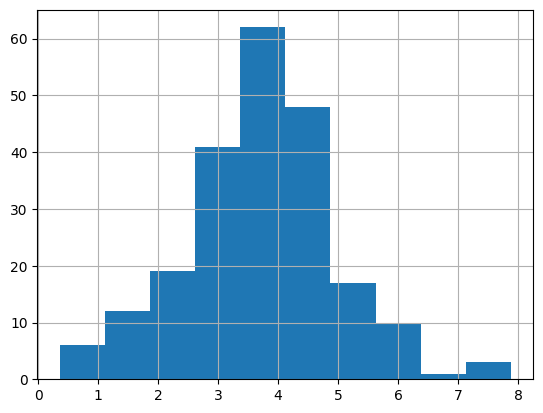

In [18]:
y_train.hist()

In [14]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [26]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sfs__n_features_to_select,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,22.976774,0.032498,0.014716,0.003238,1,{'sfs__n_features_to_select': 1},0.478811,0.640881,0.559846,0.081035,2
1,238.090097,0.073823,0.007389,0.000408,10,{'sfs__n_features_to_select': 10},0.478255,0.722695,0.600475,0.122220,1


In [27]:
grid.best_estimator_[:-1].get_feature_names_out()

array(['ATSC3pe', 'RNCG', 'C1SP2', 'Mm', 'NdCH2', 'NaaN', 'IC5',
       'PEOE_VSA10', 'EState_VSA5', 'SLogP'], dtype=object)

In [28]:
grid.best_estimator_.score(X_train, y_train)

0.801015867682145

In [29]:

grid.best_estimator_.score(X_test, y_test)

0.7447346431467485

In [137]:
from joblib import dump
dump(grid.best_estimator_,"model.joblib")

['model.joblib']